# The AIgent: Validation

### Several approaches should be taken to evaluate the AIgent, as this tool employs several different models and data types and has distinct predictive functions. Validation of genre tag prediction is straightforward (eg precision scoring) and is performed in the jupyter notebook describing construction of genre tag regressors. 

### It is more complicated to evaluate the AIgent's surfacing of similar titles (which is performed by calculating cosine similarity between a queried, embedded synopsis and a database of embedded synopses). For this task, I will determine whether embeddings from the AIgent are capable of clustering the works of different authors. I will employ a small set of highly prolific authors for this task. Embeddings will undergo dimensionality reduction to aid visualization.




## Results:

### Similar authors are well-clustered (as measured by t-SNE and PCA). Some tested authors have points that interlope with data points from other authors. Those data points are investigated in more detail and found to be one-off works in which a given author was writing outside of their typical genre (eg a fantasy writer producing a romance novel and vice-versa). These results strengthen the case of the AIgent as a content-based and high-performing tool for the surfacing of similar titles. 

In [32]:
import numpy as np
import pandas as pd
import transformers
import bert
from bert import tokenization
import torch
import transformers as ppb
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from joblib import dump, load

### Import features set (embeddings) as well as metadata (book_data)

In [3]:
features = np.load("production-ready-data/full-features-array-m9668-n20.npy")
book_data = pd.read_csv("production-ready-data/full-ids-synopses-df-m9668-n20.csv")
full_df = pd.read_csv("/Users/ryan/Projects/Insight/insight/Agent-2/agent-2/streamlit-agent/goodreads_top40k_with_ranks.csv")


### Build dataset of most prolific authors 2014-present:

In [240]:
top_authors = full_df['source_person_desc'].value_counts().head(50)
top_authors

James Patterson           708
Alexa Riley               244
Phil Noto                 126
Cassandra Clare            78
T.S. Joyce                 72
S.E. Smith                 72
Seanan McGuire             70
Nicole Snow                70
Lani Lynn Vale             69
Madison Faye               64
Rebecca Zanetti            60
Ruby Dixon                 59
Bella Forrest              59
Lauren Blakely             57
Stephen King               54
Jenika Snow                53
Sawyer Bennett             52
Giuseppe Camuncoli         52
John Sandford              51
J.S. Scott                 50
Craig Johnson              49
Kendall Ryan               49
Rachel Van Dyken           46
Erin Hunter                46
Susan Stoker               46
L. Wilder                  44
Heather Graham             44
Deborah Bladon             42
Tom King                   42
Jessica Sorensen           41
Sara Pichelli              40
Kristen Proby              39
Lisa Jackson               39
Lindsay Bu

### Build subset dataframes for each prolific author. This will aid in downstream combination.

In [567]:
stephen_king = full_df[full_df.source_person_desc == "Stephen King"].drop_duplicates(subset=['source_book_id'])
huss = full_df[full_df.source_person_desc == "J.A. Huss"].drop_duplicates(subset=['source_book_id'])
jaymin = full_df[full_df.source_person_desc == "Jaymin Eve"].drop_duplicates(subset=['source_book_id'])
rowling = full_df[full_df.source_person_desc == "J.K. Rowling"].drop_duplicates(subset=['source_book_id'])
joyce = full_df[full_df.source_person_desc == "T.S. Joyce"].drop_duplicates(subset=['source_book_id'])
patterson = full_df[full_df.source_person_desc == "James Patterson"].drop_duplicates(subset=['source_book_id'])
mcguire = full_df[full_df.source_person_desc == "Seanan McGuire"].drop_duplicates(subset=['source_book_id'])
hanna = full_df[full_df.source_person_desc == "Scott Hanna"].drop_duplicates(subset=['source_book_id'])

In [569]:
prolific_authors = pd.concat([rowling, hanna, stephen_king, mcguire, joyce])
len(prolific_authors)

145

### Trim synopses that are too long:

In [570]:
prolific_authors['token'] = prolific_authors['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
prolific_authors['token_length'] = [len(item) for item in prolific_authors.token]
prolific_authors = prolific_authors[prolific_authors['token_length'] < 500]


Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


In [571]:
len(prolific_authors)

142

### Generate feature maps for this set:

In [33]:
tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [30]:
def tokenize_synopsis(input_sentence):
    input_ids = torch.tensor(tokenizer.encode(input_sentence, add_special_tokens=True)).unsqueeze(0)
    outputs = model(input_ids)
    featurized_text = outputs[0][:,0,:].detach().numpy()
    return featurized_text

In [38]:
def padder(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    return np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [572]:
tokenized = prolific_authors['description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
padded = padder(tokenized)

In [573]:
#build tensors and run through model:
input_ids = torch.tensor(np.array(padded))
attention_mask = np.where(padded != 0, 1, 0)
attention_mask = torch.tensor(attention_mask)
with torch.no_grad():
    last_hidden_states = model(input_ids,attention_mask=attention_mask)
features = last_hidden_states[0][:,0,:].numpy()

In [574]:
features.shape

(142, 768)

## Plot results w/ dimensionality reduction:

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [372]:
rndperm = np.random.permutation(prolific_test.shape[0])
pca = PCA(n_components=3, whiten=True)
pca_result = pca.fit_transform(features)

In [361]:
from sklearn.preprocessing import LabelEncoder 

In [583]:
labelencoder= LabelEncoder() #initializing an object of class LabelEncoder
prolific_test['colors'] = labelencoder.fit_transform(prolific_test['source_person_desc'])

In [365]:
prolific_test.colors.unique()

array([0, 3, 1, 4, 5, 2])

In [373]:
prolific_test['pca-one'] = pca_result[:,0]
prolific_test['pca-two'] = pca_result[:,1] 
prolific_test['pca-three'] = pca_result[:,2]

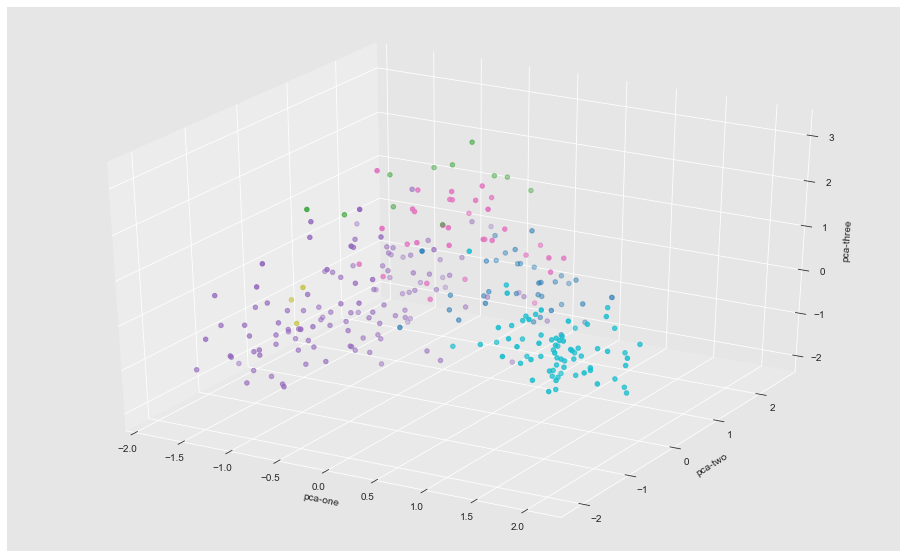

In [374]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=prolific_test["colors"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [97]:
from sklearn.manifold import TSNE

In [586]:
tsne = TSNE(n_components=2, random_state=42,verbose=1, perplexity=50, n_iter=10000, learning_rate=5, method='exact')
tsne_results = tsne.fit_transform(features)


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 142 / 142
[t-SNE] Mean sigma: 1.517626
[t-SNE] KL divergence after 50 iterations with early exaggeration: 40.276089
[t-SNE] KL divergence after 350 iterations: 0.201662


In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

In [587]:
#prolific_test = prolific_authors.copy()
prolific_test['tsne_x'] = tsne_results[:,0]
prolific_test['tsne_y'] = tsne_results[:,1]


In [581]:
prolific_test['tsne_z'] = tsne_results[:,2]


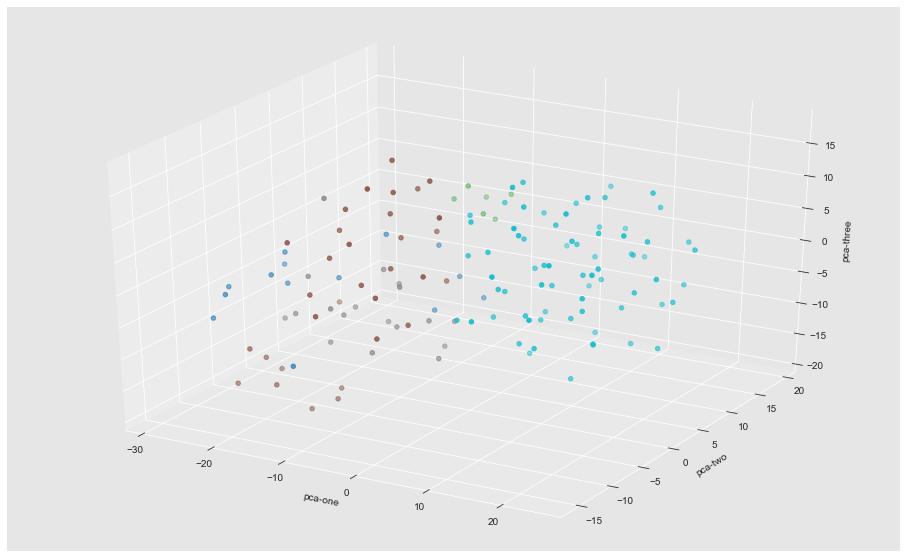

In [584]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_results[:,0], 
    ys=tsne_results[:,1], 
    zs=tsne_results[:,2], 
    c=prolific_test["colors"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Good separation by PCA, but a better plot may be t-SNE, which gives better measures of within-class similarity, as opposed to between-class dissimilarity.

In [ ]:
plt.figure(figsize=(12,8))

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
#labels = ["J.A. Huss", "Jaymin Eve", "J.K. Rowling", "T.S. Joyce", "Robert Galbraith", "James Patterson"]
labels = ["JK Rowling", "Jim Patterson", "Stephen King", "Seanan McGuire", "TS Joyce"]
plt.legend(handles, fontsize='40')
palette = sns.color_palette("bright", 5)
plt.legend(loc=2, prop={'size': 12})
ax = sns.scatterplot(tsne_results[:,0],tsne_results[:,1], s=100,data=prolific_test, linewidth=1, alpha=0.7,
                 edgecolor="black", palette=palette, hue=prolific_test['source_person_desc'], legend='full')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
plt.title("t-SNE embedding of book synopses", fontsize='20')
plt.savefig("T-sne-top-five.png", bbox_inches = 'tight',
    pad_inches = .1)

In [1]:
###build a color palette:

plt.figure(figsize=(12,8))

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
labels = ["JK Rowling", "Scott Hanna", "Stephen King", "Seanan McGuire", "TS Joyce"]
plt.legend(handles, fontsize='40')
palette = sns.color_palette("bright", 5)
plt.legend(loc=2, prop={'size': 12})
ax = sns.scatterplot(tsne_results[:,0],tsne_results[:,1], s=100,data=prolific_test, linewidth=1, alpha=0.7,
                 edgecolor="black", palette=palette, hue=prolific_test['source_person_desc'], legend='full')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
plt.title("t-SNE embedding of book synopses", fontsize='20')
plt.savefig("T-sne-top-five.png", bbox_inches = 'tight',
    pad_inches = .1)

NameError: name 'plt' is not defined